In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("dataset_for_sirius.csv", sep=';')



In [ ]:
from sklearn.cluster import KMeans

rfm_df = df.groupby('id').agg({
    'expiration_minus_1d_dt': lambda x: (pd.to_datetime(df['expiration_minus_1d_dt'].max()) - pd.to_datetime(x).max()).days,
    'renewal_cnt': 'sum',
    'renewal_amt': lambda x: pd.to_numeric(x.str.replace('<', '').str.replace('>=', '').str.replace('>', ''), errors='coerce').sum()
}).rename(columns={
    'expiration_minus_1d_dt': 'Recency',
    'renewal_cnt': 'Frequency',
    'renewal_amt': 'Monetary'
}).reset_index()


rfm_df = rfm_df.fillna(0)


kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

rfm_df.head()

,id,Recency,Frequency,Monetary,Cluster
0,1,45,1,1400000,2
1,2,333,1,1400000,2
2,3,38,2,1000000,2
3,5,286,1,500000,0
4,6,281,1,100000,0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\bulie\AppData\Local\Temp\ipykernel_26452\998125753.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='Cluster', palette='viridis')


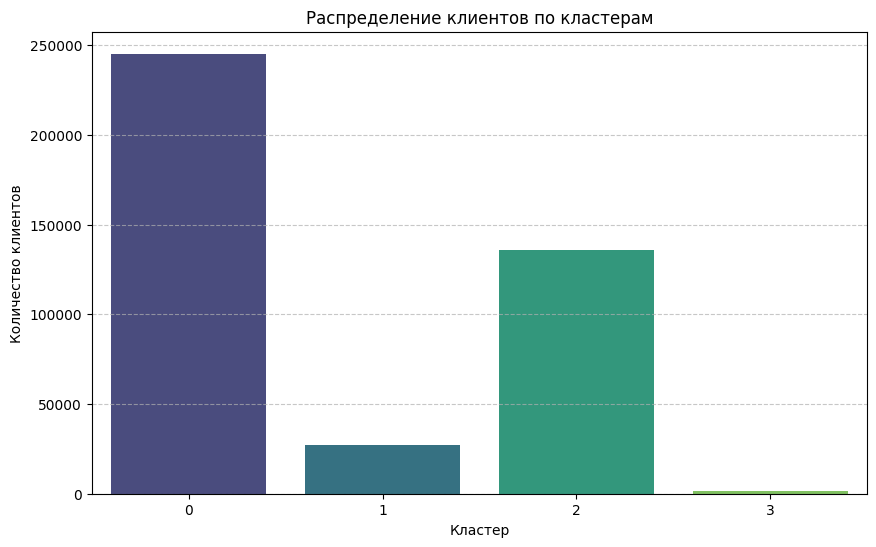

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_df, x='Cluster', palette='viridis')
plt.title('Распределение клиентов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

X = rfm_df[['Recency', 'Frequency', 'Monetary']]
labels = rfm_df['Cluster']
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.3f}")

if score > 0.5:
    print("The clustering structure is strong and well separated.")
elif score > 0.3:
    print("The clustering structure is reasonable.")
elif score > 0.1:
    print("The clustering structure is weak and could be improved.")
else:
    print("No substantial structure was found.")

Silhouette Score: 0.771
The clustering structure is strong and well separated.


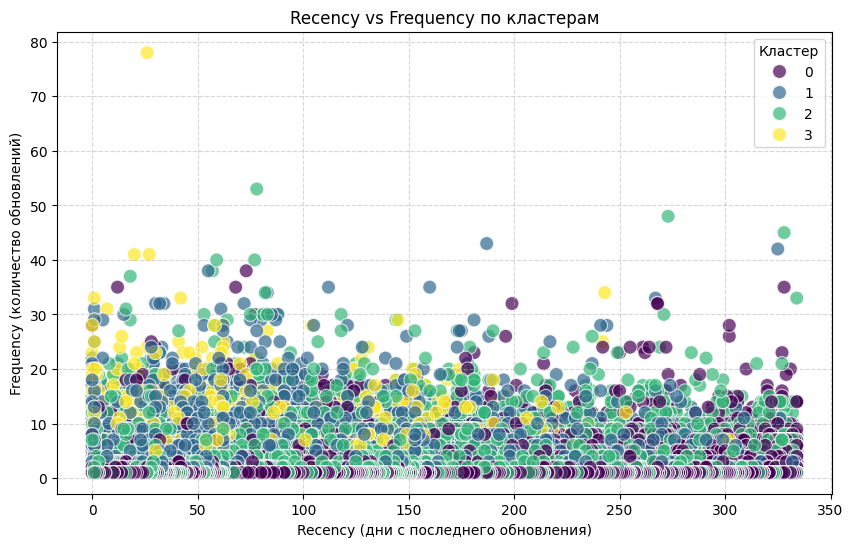

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm_df,
    x='Recency',
    y='Frequency',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('Recency vs Frequency по кластерам')
plt.xlabel('Recency (дни с последнего обновления)')
plt.ylabel('Frequency (количество обновлений)')
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Кластер')
plt.show()

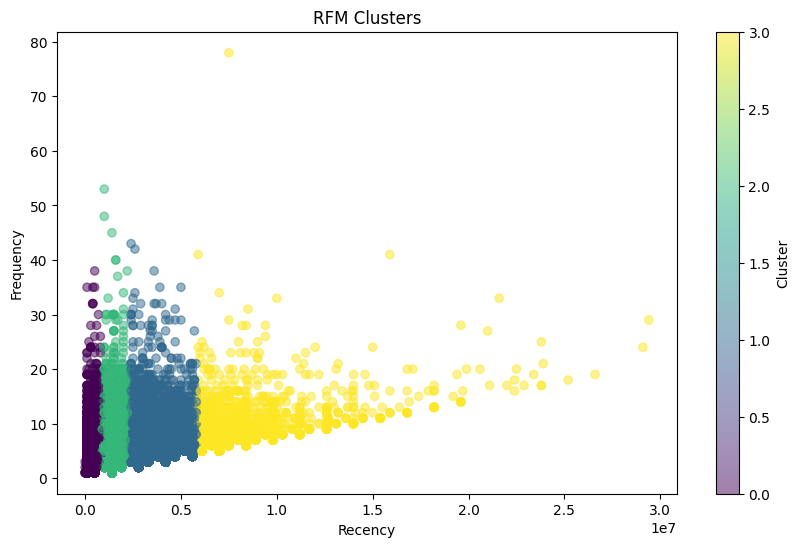

In [ ]:

cluster_medians = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()
print(cluster_medians)

         Recency  Frequency   Monetary
Cluster                               
0          154.0        1.0   500000.0
1           86.0        3.0  2800000.0
2          125.0        2.0  1400000.0
3           62.0        8.0  7500000.0


In [ ]:
len(set(df['id']))

409895

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv("dataset_for_sirius.csv", sep=';')

# Порядковое кодирование
ordinal_mapping = {
    '<100000': 1,
    '<500000': 2,
    '<1400000': 3,
    '>=1400000': 4
}

df['renewal_amt_ordinal'] = df['renewal_amt'].map(ordinal_mapping)

# Масштабирование порядковых значений
scaler_ord = StandardScaler()
df['renewal_amt_ordinal_scaled'] = scaler_ord.fit_transform(df[['renewal_amt_ordinal']])

# Создаем DataFrame с нужными столбцами
df_cluster = df[['id', 'months_cnt', 'renewal_cnt', 'renewal_amt_ordinal_scaled']].copy()



X = df_cluster[['months_cnt', 'renewal_cnt', 'renewal_amt_ordinal_scaled']]

In [ ]:
X = X.dropna()
df_cluster = df_cluster.dropna()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv("dataset_for_sirius.csv", sep=';')


ordinal_mapping = {
    '<500': 0,
    '<1000': 1,
    '<50000': 20,
    '<100000': 100,
    '<500000': 200,
    '<1400000': 1000,
    '>=1400000': 2800
}

df['renewal_amt_ordinal'] = df['renewal_amt'].map(ordinal_mapping)


df_cluster = df[['id', 'months_cnt', 'renewal_cnt', 'renewal_amt_ordinal']].copy()

X = df_cluster[['months_cnt', 'renewal_cnt', 'renewal_amt_ordinal']]

X = X.dropna()
df_cluster = df_cluster.dropna()

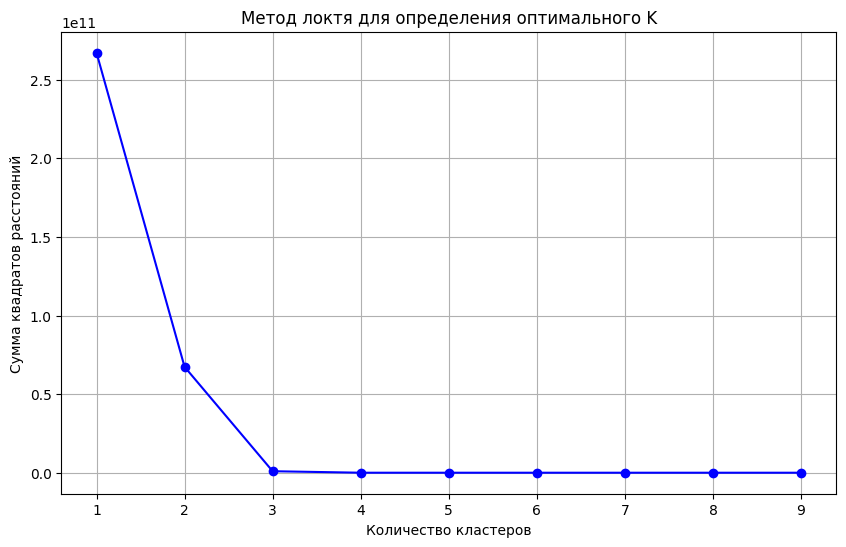

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального K')
plt.grid(True)
plt.show()

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['kmeans_cluster'] = kmeans.fit_predict(X)

In [ ]:
from sklearn.metrics import silhouette_score

X = df_cluster[['months_cnt', 'renewal_cnt', 'renewal_amt_ordinal']]
labels = df_cluster['kmeans_cluster']
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.3f}")


if score > 0.5:
    print("The clustering structure is strong and well separated.")
elif score > 0.3:
    print("The clustering structure is reasonable.")
elif score > 0.1:
    print("The clustering structure is weak and could be improved.")
else:
    print("No substantial structure was found.")

KeyboardInterrupt: 

In [ ]:
df_cluster['kmeans_cluster'].value_counts()

kmeans_cluster
0    435086
2    122904
1     35441
Name: count, dtype: int64

In [ ]:
cluster_medians = df_cluster.groupby('kmeans_cluster')[['months_cnt', 'renewal_cnt', 'renewal_amt_ordinal']].median()
print(cluster_medians)

                months_cnt  renewal_cnt  renewal_amt_ordinal
kmeans_cluster                                              
0                      3.0          1.0                200.0
1                      3.0          1.0               2800.0
2                      3.0          1.0               1000.0


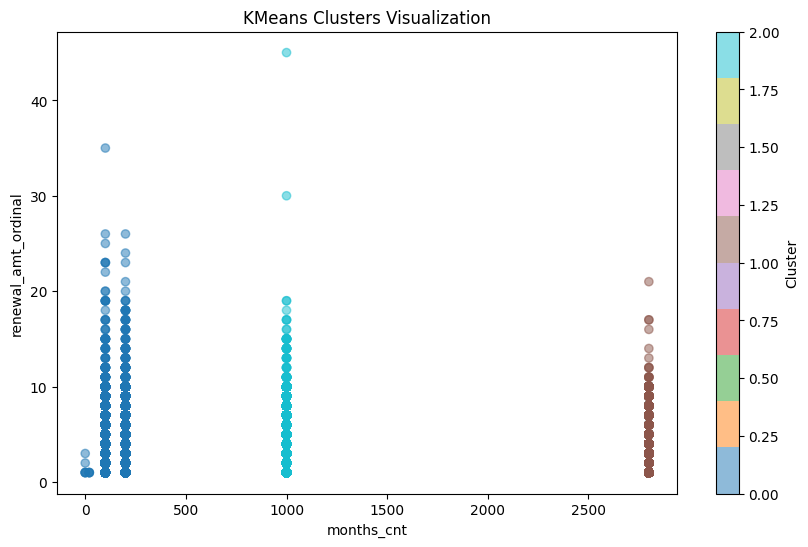

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X['renewal_amt_ordinal'],
    X['renewal_cnt'],
    c=df_cluster['kmeans_cluster'],
    cmap='tab10',
    alpha=0.5
)
plt.xlabel('months_cnt')
plt.ylabel('renewal_amt_ordinal')
plt.title('KMeans Clusters Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [ ]:
df['cluster'] = df_cluster['kmeans_cluster']
df

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,...,diff_vtb_24_mean,diff_vtb_12_mean,diff_vtb_6_mean,diff_vtb_3_mean,diff_alfa_bank_24_mean,diff_alfa_bank_12_mean,diff_alfa_bank_6_mean,diff_alfa_bank_3_mean,renewal_amt_ordinal,cluster
0,2024-03-18,65757,0,<100000,<500,<500000,<50000,<100000,NaN,<50000,...,4.210,0.550000,0.010000,0.680,0.217500,1.837500,1.445000,1.490000,100.0,0.0
1,2024-05-26,302422,0,<1400000,<500,<1400000,NaN,<50000,<500000,<50000,...,4.765,0.610000,0.540000,0.425,0.408000,1.688000,1.638000,1.080000,1000.0,2.0
2,2024-02-22,325078,0,<1400000,<500,>=1400000,NaN,<50000,<100000,<10000,...,4.840,-0.020000,0.010000,0.680,0.847500,1.267500,1.245000,1.490000,1000.0,2.0
3,2024-01-15,284248,0,<500000,<1000,<1400000,<500000,<500000,NaN,<10000,...,4.840,-0.020000,0.646667,0.680,1.073333,1.830000,1.883333,2.206667,200.0,0.0
4,2024-02-24,151409,1,<500000,<10000,<500000,<500000,<100000,<500000,<50000,...,4.840,-0.020000,0.010000,0.680,0.847500,1.267500,1.245000,1.490000,200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593428,2024-10-29,337410,0,<500000,<500,<500000,NaN,<100000,NaN,<50000,...,1.280,1.641667,1.103333,-1.160,1.055000,2.181667,1.230000,-0.113929,200.0,0.0
593429,2024-02-25,178536,0,<100000,<500,<500000,<50000,<500000,<50000,<10000,...,4.840,-0.020000,0.010000,0.680,0.847500,1.267500,1.245000,1.490000,100.0,0.0
593430,2024-10-31,508828,0,<100000,<500,<100000,<50000,<100000,NaN,<10000,...,1.280,1.641667,1.103333,-1.160,1.055000,2.181667,1.230000,-0.113929,100.0,0.0
593431,2024-11-01,73886,0,<100000,<500,<1400000,<100000,<100000,<500000,<10000,...,1.280,1.641667,1.103333,-1.160,1.055000,2.181667,1.230000,-0.113929,100.0,0.0


In [ ]:

for cluster_value in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster_value]
    cluster_df.to_csv(f"cluster_{cluster_value}.csv", index=False, sep=';')
    print(f"Cluster {cluster_value} saved to 'cluster_{cluster_value}.csv'")


Cluster 0.0 saved to 'cluster_0.0.csv'
Cluster 2.0 saved to 'cluster_2.0.csv'
Cluster 1.0 saved to 'cluster_1.0.csv'
Cluster nan saved to 'cluster_nan.csv'


In [ ]:
df_cluster = df_cluster.drop(['months_cnt', 'renewal_cnt', 'renewal_amt_ordinal_scaled'], axis=1)
df_cluster

,id,kmeans_cluster
0,65757,0
1,302422,1
2,325078,0
3,284248,2
4,151409,0
...,...,...
593428,337410,0
593429,178536,1
593430,508828,0
593431,73886,0


In [ ]:

df = df.merge(df_cluster, on='id', how='left')
df

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,...,diff_gazprombank_3_mean,diff_vtb_24_mean,diff_vtb_12_mean,diff_vtb_6_mean,diff_vtb_3_mean,diff_alfa_bank_24_mean,diff_alfa_bank_12_mean,diff_alfa_bank_6_mean,diff_alfa_bank_3_mean,kmeans_cluster
0,2024-03-18,65757,0,<100000,<500,<500000,<50000,<100000,NaN,<50000,...,-0.5050,4.210,0.550000,0.010000,0.680,0.2175,1.837500,1.445,1.490000,0.0
1,2024-05-26,302422,0,<1400000,<500,<1400000,NaN,<50000,<500000,<50000,...,-0.9000,4.765,0.610000,0.540000,0.425,0.4080,1.688000,1.638,1.080000,1.0
2,2024-05-26,302422,0,<1400000,<500,<1400000,NaN,<50000,<500000,<50000,...,-0.9000,4.765,0.610000,0.540000,0.425,0.4080,1.688000,1.638,1.080000,0.0
3,2024-02-22,325078,0,<1400000,<500,>=1400000,NaN,<50000,<100000,<10000,...,-0.5050,4.840,-0.020000,0.010000,0.680,0.8475,1.267500,1.245,1.490000,0.0
4,2024-02-22,325078,0,<1400000,<500,>=1400000,NaN,<50000,<100000,<10000,...,-0.5050,4.840,-0.020000,0.010000,0.680,0.8475,1.267500,1.245,1.490000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318856,2024-11-01,73886,0,<100000,<500,<1400000,<100000,<100000,<500000,<10000,...,-1.6425,1.280,1.641667,1.103333,-1.160,1.0550,2.181667,1.230,-0.113929,0.0
1318857,2024-11-01,73886,0,<100000,<500,<1400000,<100000,<100000,<500000,<10000,...,-1.6425,1.280,1.641667,1.103333,-1.160,1.0550,2.181667,1.230,-0.113929,0.0
1318858,2024-02-07,307380,1,<100000,<1000,<500000,<50000,<500000,<500000,<50000,...,-0.5050,4.840,-0.020000,0.010000,0.680,0.9225,1.515000,1.645,1.890000,1.0
1318859,2024-02-07,307380,1,<100000,<1000,<500000,<50000,<500000,<500000,<50000,...,-0.5050,4.840,-0.020000,0.010000,0.680,0.9225,1.515000,1.645,1.890000,0.0


np.float64(-299.0)

In [ ]:

correlation_df = df[df['credit_amt_opn_rev_sum'] > 0][['credit_amt_opn_rev_sum', 'renewal_amt']]

correlation_df = correlation_df.dropna()
correlation = correlation_df['credit_amt_opn_rev_sum'].corr(correlation_df['renewal_amt'])
print(f"Correlation between outstnd_amt_opn_nrev_sum  and renewal_amt for users with outstnd_amt_opn_nrev_sum > 0: {correlation:.3f}")

correlation_df_zero = df[df['credit_amt_opn_rev_sum'] == 0][['credit_amt_opn_rev_sum', 'renewal_amt']]
correlation_df_zero = correlation_df_zero.dropna()
correlation_zero = correlation_df_zero['credit_amt_opn_rev_sum'].corr(correlation_df_zero['renewal_amt'])
print(f"Correlation between outstnd_amt_opn_nrev_sum  and renewal_amt for users with outstnd_amt_opn_nrev_sum == 0: {correlation_zero:.3f}")


Correlation between outstnd_amt_opn_nrev_sum  and renewal_amt for users with outstnd_amt_opn_nrev_sum > 0: 0.045
Correlation between outstnd_amt_opn_nrev_sum  and renewal_amt for users with outstnd_amt_opn_nrev_sum == 0: nan


c:\Users\bulie\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\bulie\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between credit_amt_opn_rev_sum and renewal_amt for cluster 0.0: -0.019
Correlation between credit_amt_opn_rev_sum and renewal_amt for cluster 1.0: nan
Correlation between credit_amt_opn_rev_sum and renewal_amt for cluster 2.0: nan


Missing values in 'cred_av_log': 40764
count    552669.000000
mean         11.918395
std           1.945809
min           7.824050
25%           9.615810
50%          11.995110
75%          13.538460
max          20.959650
Name: cred_av_log, dtype: float64


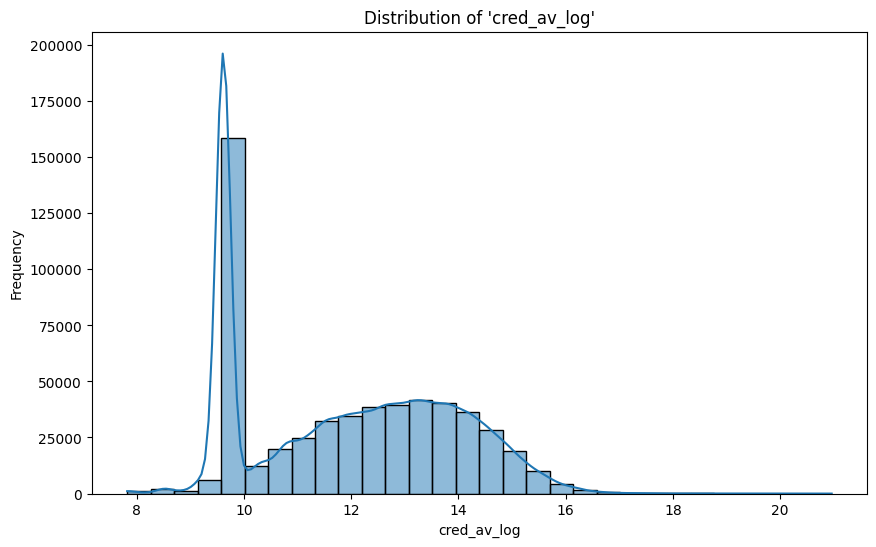

In [ ]:
import seaborn as sns


missing_cred_av_log = df['cred_av_log'].isna().sum()
print(f"Missing values in 'cred_av_log': {missing_cred_av_log}")

print(df['cred_av_log'].describe())





In [ ]:
rfm_df.to_csv('rfm_df.csv', index=False)

In [ ]:
df

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,...,diff_gazprombank_6_mean,diff_gazprombank_3_mean,diff_vtb_24_mean,diff_vtb_12_mean,diff_vtb_6_mean,diff_vtb_3_mean,diff_alfa_bank_24_mean,diff_alfa_bank_12_mean,diff_alfa_bank_6_mean,diff_alfa_bank_3_mean
0,2024-03-18,65757,0,<100000,<500,<500000,<50000,<100000,NaN,<50000,...,-0.482500,-0.5050,4.210,0.550000,0.010000,0.680,0.217500,1.837500,1.445000,1.490000
1,2024-05-26,302422,0,<1400000,<500,<1400000,NaN,<50000,<500000,<50000,...,-0.338000,-0.9000,4.765,0.610000,0.540000,0.425,0.408000,1.688000,1.638000,1.080000
2,2024-02-22,325078,0,<1400000,<500,>=1400000,NaN,<50000,<100000,<10000,...,-0.482500,-0.5050,4.840,-0.020000,0.010000,0.680,0.847500,1.267500,1.245000,1.490000
3,2024-01-15,284248,0,<500000,<1000,<1400000,<500000,<500000,NaN,<10000,...,0.752500,1.5425,4.840,-0.020000,0.646667,0.680,1.073333,1.830000,1.883333,2.206667
4,2024-02-24,151409,1,<500000,<10000,<500000,<500000,<100000,<500000,<50000,...,-0.482500,-0.5050,4.840,-0.020000,0.010000,0.680,0.847500,1.267500,1.245000,1.490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593428,2024-10-29,337410,0,<500000,<500,<500000,NaN,<100000,NaN,<50000,...,0.135333,-1.6425,1.280,1.641667,1.103333,-1.160,1.055000,2.181667,1.230000,-0.113929
593429,2024-02-25,178536,0,<100000,<500,<500000,<50000,<500000,<50000,<10000,...,-0.482500,-0.5050,4.840,-0.020000,0.010000,0.680,0.847500,1.267500,1.245000,1.490000
593430,2024-10-31,508828,0,<100000,<500,<100000,<50000,<100000,NaN,<10000,...,0.135333,-1.6425,1.280,1.641667,1.103333,-1.160,1.055000,2.181667,1.230000,-0.113929
593431,2024-11-01,73886,0,<100000,<500,<1400000,<100000,<100000,<500000,<10000,...,0.135333,-1.6425,1.280,1.641667,1.103333,-1.160,1.055000,2.181667,1.230000,-0.113929


In [ ]:
df0 = pd.read_csv('cluster_0_clean.csv')

In [ ]:
len(set(df0['id']))/len(set(df['id']))

0.7520974883811707